# Point-to-Point space charge example

This uses a basic APEX Gun example with a reduced voltage and artificially reduced frequency. 

Warning from Ji: The # of electrons divided by the number of processors should be an integer.


In [1]:
from impact import Impact
from distgen import Generator
import os

from pmd_beamphysics.units import e_charge, mec2

import matplotlib.pyplot as plt


In [2]:
IMPACT_IN =  'templates/apex_gun/ImpactT.in'
os.path.exists(IMPACT_IN)

True

# Prepare particles

Prepare 100 electrons in a 1 µm uniform spot.

In [3]:
DISTGEN_IN = """
n_particle: 100
species: electron
r_dist:
  max_r: 1000 nm
  type: radial_uniform
random:
  type: hammersley
start:
  MTE: 30 meV
  type: cathode
t_dist:
  avg_t: 0 fs
  sigma_t: 29.0 fs
  type: gaussian
total_charge: 1.602176634e-17 C
"""

<disgten.Generator with input: 
n_particle: 100
output:
  type: null
r_dist:
  max_r:
    units: nanometer
    value: 1000
  type: radial_uniform
random:
  type: hammersley
species: electron
start:
  MTE:
    units: millielectron_volt
    value: 30
  type: cathode
t_dist:
  avg_t:
    units: femtosecond
    value: 0
  sigma_t:
    units: femtosecond
    value: 29.0
  type: gaussian
total_charge:
  units: coulomb
  value: 1.602176634e-17
transforms: null

>

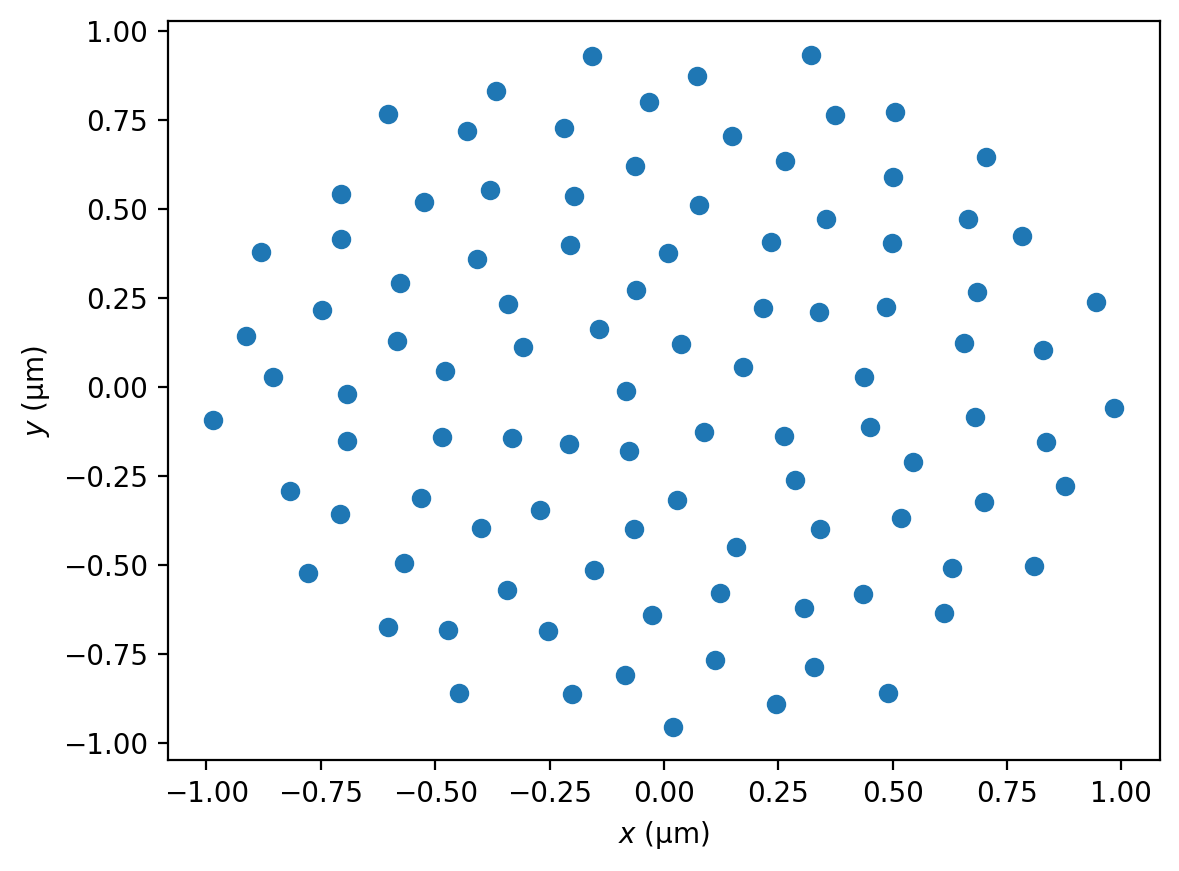

In [4]:
G = Generator(DISTGEN_IN)
G['n_particle'] = 100
# Set individual electrons
G['total_charge:value'] = e_charge * G['n_particle']

G.run()
P0 = G.particles

fig, ax = plt.subplots()
ax.scatter(P0.x*1e6, P0.y*1e6)
ax.set_xlabel(r'$x$ (µm)')
ax.set_ylabel(r'$y$ (µm)')
G


# Run Impact-T

Make a function to compare variations of the space charge calc. 

In [5]:
def make_impact(initial_particles, 
               space_charge_on=False,
               point_to_point = True,
               ):
    # Make Impact object
    I = Impact(IMPACT_IN)
    I.header['Nx'] = 16 # Larger numbers seem to give errors below.
    I.header['Ny'] = 16
    I.header['Nz'] = 64
    
    I.initial_particles = initial_particles
    if space_charge_on:
        I.total_charge = initial_particles['charge']
    else:
        I.total_charge = 0
    
    # Patch in point_to_point_spacecharge
    
    if point_to_point:
        ELE =  {
          'type': 'point_to_point_spacecharge',
          'cutoff_radius': 2.8179e-15, # classical electron radius
          'name': 'point_to_point_calc',
        }
    else:
        ELE = I.lattice[0]
    I.input['lattice'] = [
        ELE,
        I.lattice[2],
        I.lattice[-2] ]
    
    I.header['Dt'] = 1e-13 
    I.stop = 0.15
    
    I.ele['APEX_GUN']['rf_frequency'] = 1 # Like a DC gun
    I.ele['APEX_GUN']['rf_field_scale'] = 0.4e6
    
    return I

I0 = make_impact(P0, space_charge_on=False)
I1 = make_impact(P0, space_charge_on=True)
I2 = make_impact(P0, space_charge_on=True, point_to_point=False)


I1.lattice

[{'type': 'point_to_point_spacecharge',
  'cutoff_radius': 2.8179e-15,
  'name': 'point_to_point_calc'},
 {'description': 'name:APEX_GUN',
  'original': '0.199 105 20 105 0.0 20e6 0.187e9 171.45508468896992 30.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 /!name:APEX_GUN',
  'L': 0.199,
  'type': 'solrf',
  'zedge': 0.0,
  'rf_field_scale': 400000.0,
  'rf_frequency': 1,
  'theta0_deg': 171.45508468896992,
  'filename': 'rfdata30',
  'radius': 0.1,
  'x_offset': 0.0,
  'y_offset': 0.0,
  'x_rotation': 0.0,
  'y_rotation': 0.0,
  'z_rotation': 0.0,
  'solenoid_field_scale': 0.0,
  's': 0.199,
  'name': 'APEX_GUN'},
 {'name': 'stop_1', 'type': 'stop', 's': 0.15}]

# Run

In [6]:
%%time
I0.verbose=False
I0.run()

CPU times: user 105 ms, sys: 61.3 ms, total: 167 ms
Wall time: 1.83 s


In [7]:
%%time
# Warning: The # of electrons divided by the number of processors should be an integer.
I1.numprocs = 4
I1.verbose=False
I1.run()

CPU times: user 104 ms, sys: 53 ms, total: 157 ms
Wall time: 2.64 s


In [8]:
%%time
I2.numprocs = 8 # Best for M1. 
I2.verbose=False
I2.run()

CPU times: user 355 ms, sys: 150 ms, total: 505 ms
Wall time: 43.8 s


In [9]:
I1.path

'/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpyj21vlqp'

In [10]:
!cat {I1.path}/ImpactT.in

! Impact-T input file
!Npcol Nprow
1 4
!Dt Ntstep Nbunch
1e-13 1000000 1
!Dim Np Flagmap Flagerr Flagdiag Flagimg Zimage
6 100 1 0 2 1 0.02
!Nx Ny Nz Flagbc Xrad Yrad Perdlen
16 16 64 1 0.015 0.015 45.0
!Flagdist Rstartflg Flagsbstp Nemission Temission
16 0 0 400 1.430106736047842e-13
!sigx(m) sigpx muxpx xscale pxscale xmu1(m) xmu2
0.0006 0.0 0.0 1.0 1.0 0.0 0.0
!sigy(m) sigpy muxpy yscale pyscale ymu1(m) ymu2
0.0006 0.0 0.0 1.0 1.0 0.0 0.0
!sigz(m) sigpz muxpz zscale pzscale zmu1(m) zmu2
1.27e-06 0.0 0.0 1.0 1.0 0.0 0.0
!Bcurr Bkenergy Bmass Bcharge Bfreq Tini
2.0828296241999998e-08 1.0 511005.0 -1.0 1300000000.0 -7.619385117953186e-14
!=================== LATTICE ===================
0 0 0 -15 0 0 2.8179e-15 /!name:point_to_point_calc
0.199 0 0 105 0.0 400000.0 1 171.45508468896992 30 0.1 0.0 0.0 0.0 0.0 0.0 0.0 /!name:APEX_GUN
0 0 0 -99 0.15 0.0 0.15 /!name:stop_1


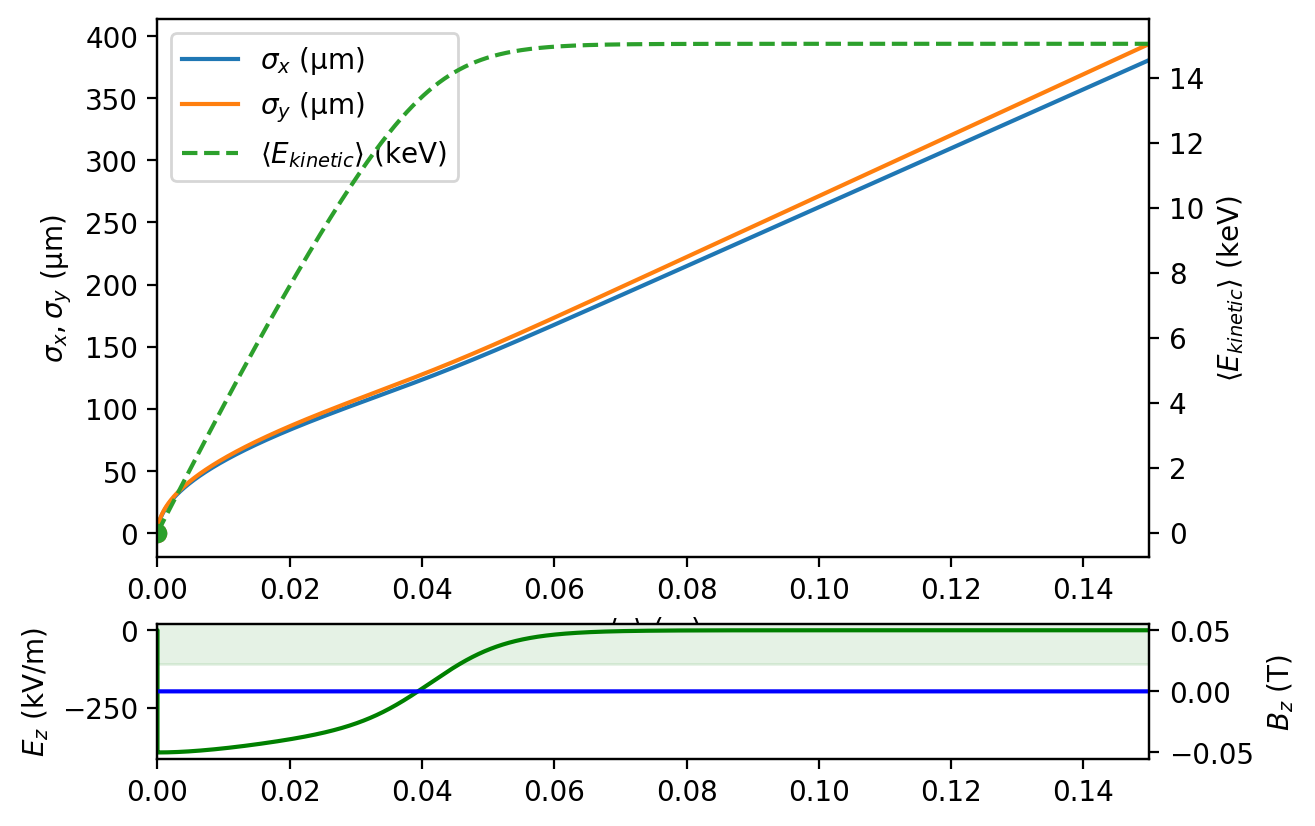

In [11]:
I1.plot(y2='mean_kinetic_energy')

# Compare space charge off, on

In [12]:
Poff    = I0.particles['final_particles']
Pon     = I1.particles['final_particles']
PonIGF  = I2.particles['final_particles']

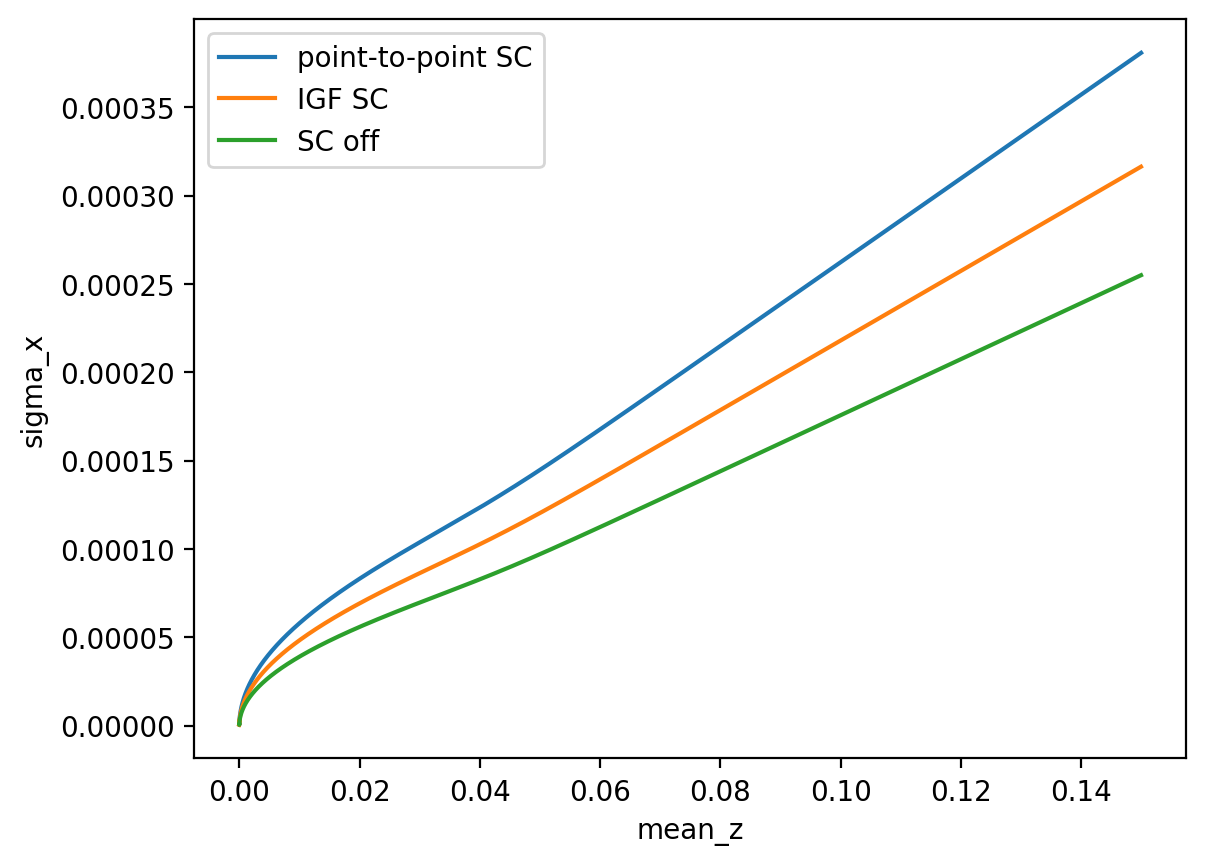

In [13]:
def compare_stats(k2, k1='mean_z', scale1=1, scale2=1):
    fig, ax = plt.subplots()
    for I, label in (     
        (I1, "point-to-point SC"),
        (I2, "IGF SC"),
        (I0, "SC off"),
    ):
        ax.plot(I.stat(k1)*scale1, I.stat(k2)*scale2, label=label)
    ax.set_xlabel(k1)
    ax.set_ylabel(k2)
    plt.legend()
compare_stats('sigma_x')

In [14]:
I1.output['stats'].keys()

dict_keys(['t', 'mean_z', 'mean_gamma', 'mean_beta', 'max_r', 'sigma_gamma', 'mean_x', 'sigma_x', 'norm_emit_x', 'mean_y', 'sigma_y', 'norm_emit_y', 'sigma_z', 'norm_emit_z', 'max_amplitude_x', 'max_amplitude_y', 'max_amplitude_z', 'loadbalance_min_n_particle', 'loadbalance_max_n_particle', 'n_particle', 'moment3_x', 'moment3_y', 'moment3_z', 'moment4_x', 'moment4_y', 'moment4_z', 'cov_x__x', 'cov_x__y', 'cov_x__z', 'cov_y__y', 'cov_y__z', 'cov_z__z', 'mean_kinetic_energy', 'cov_x__px', 'cov_y__py', 'cov_z__pz', 'cov_x__py', 'cov_x__pz', 'cov_px__px', 'cov_y__px', 'cov_px__py', 'cov_z__px', 'cov_px__pz', 'cov_y__pz', 'cov_py__py', 'cov_z__py', 'cov_py__pz', 'cov_pz__pz'])

Text(0, 0.5, '$\\sigma_E$ (eV)')

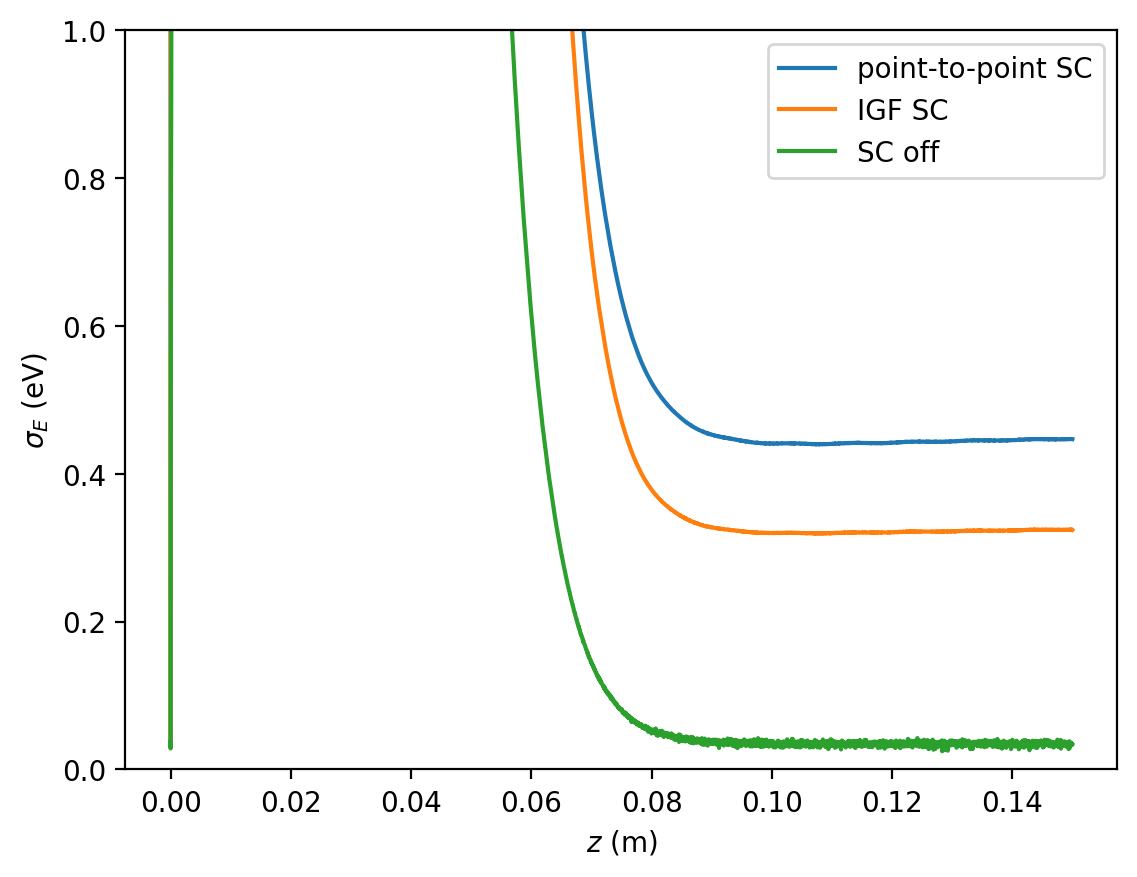

In [15]:
compare_stats('sigma_gamma', scale2=mec2 )
plt.ylim(0, 1)
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\sigma_E$ (eV)')

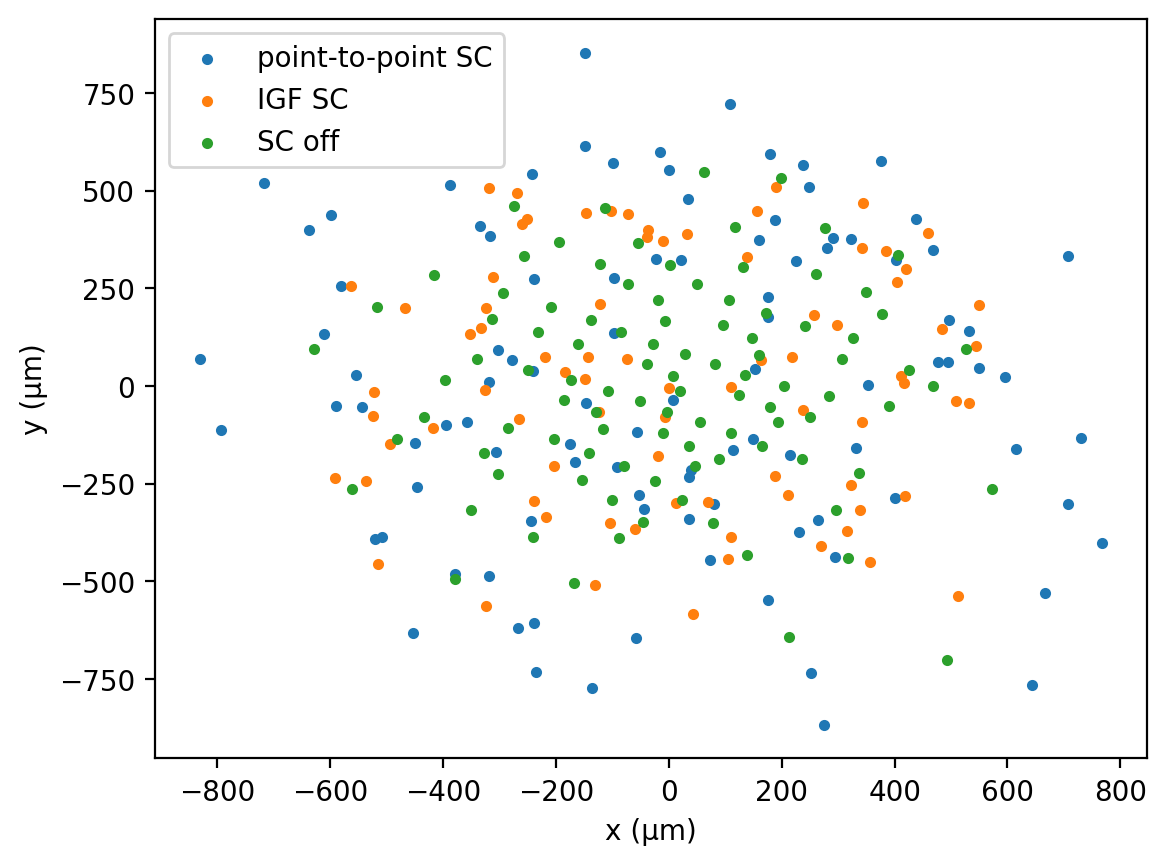

In [16]:
def compare_particles(k1, k2, scale1=1, scale2=1, units1='', units2=''):
    fig, ax = plt.subplots()
    for p, label in (
                     (Pon, "point-to-point SC"),
                     (PonIGF, "IGF SC"),
                     (Poff, "SC off"),
                    ):
        ax.scatter(p[k1]*scale1, p[k2]*scale2, marker='.', label=label)
    ax.set_xlabel(k1+units1)
    ax.set_ylabel(k2+units2)
    plt.legend()
compare_particles('x', 'y', scale1=1e6, scale2=1e6, units1=' (µm)', units2=' (µm)', )

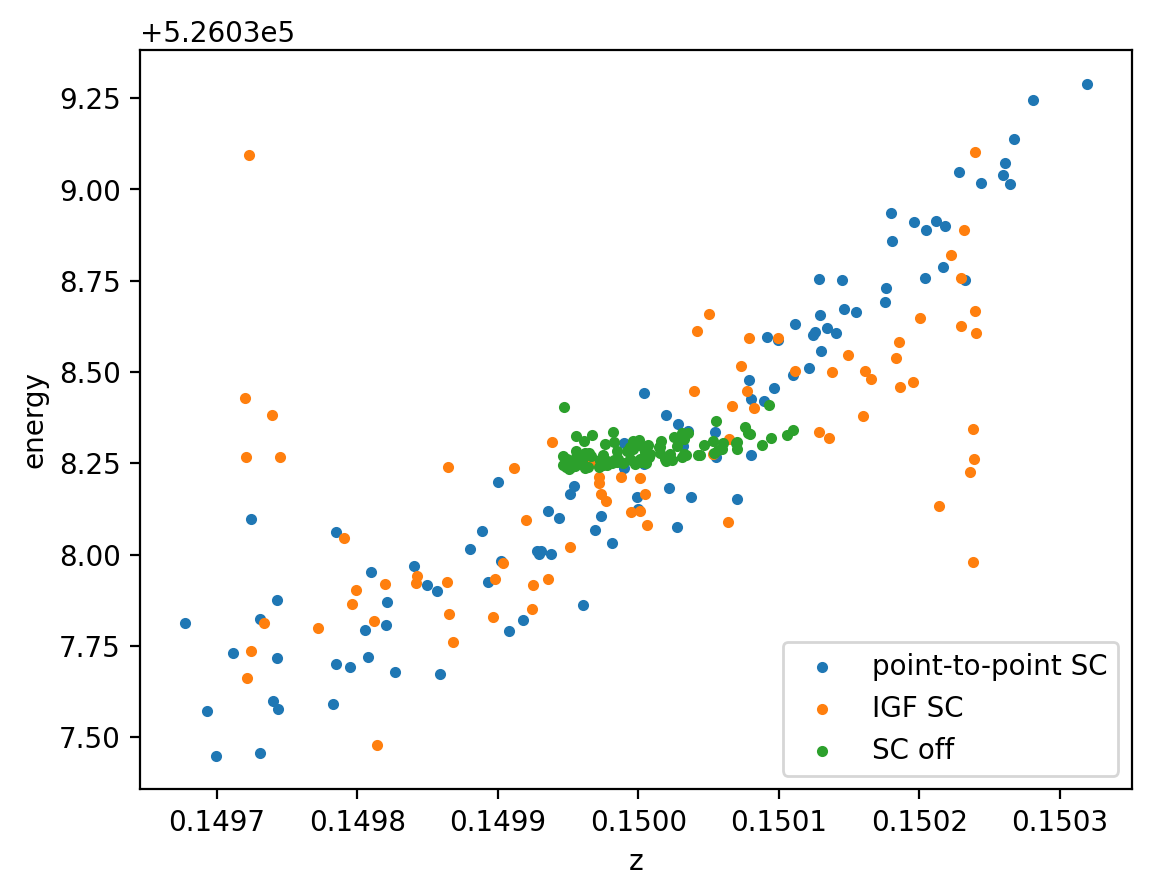

In [17]:
compare_particles('z', 'energy')

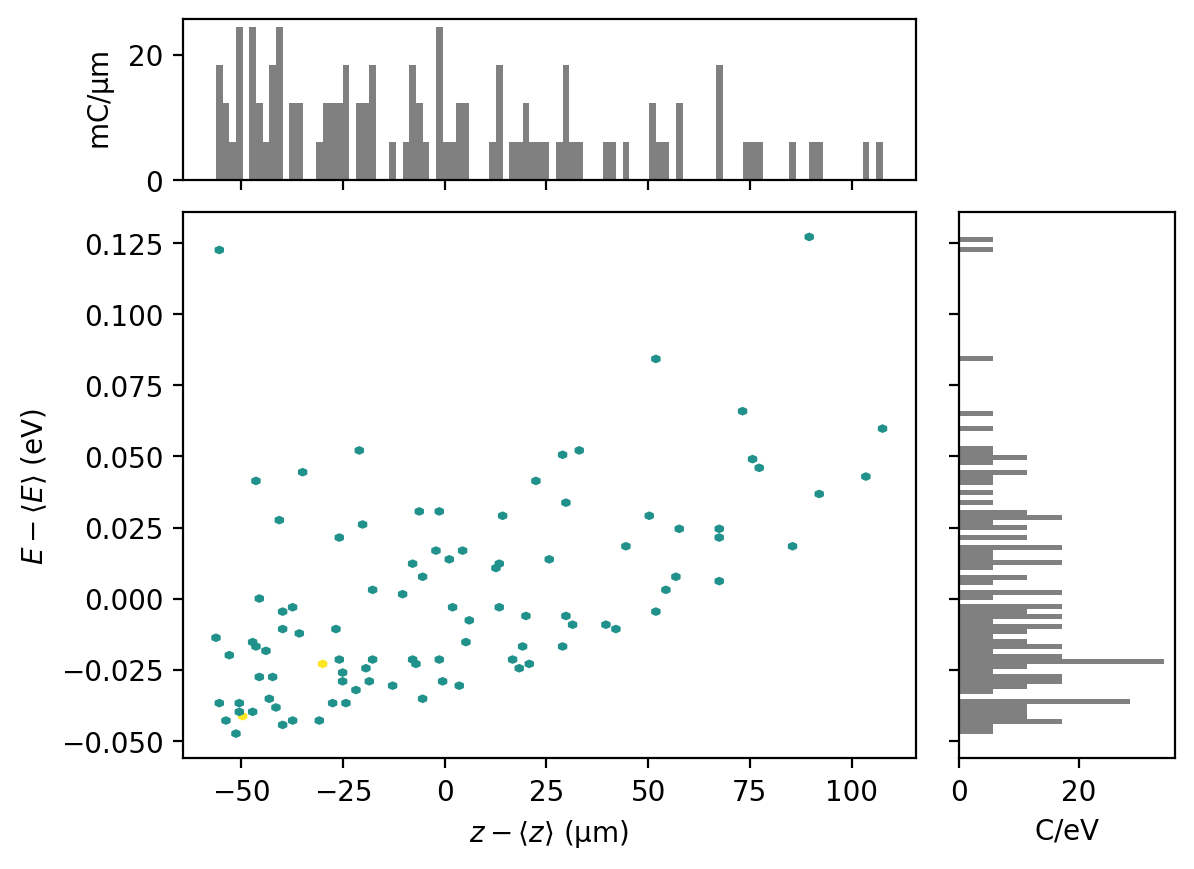

In [18]:
Poff.plot('delta_z', 'delta_energy', bins=100)

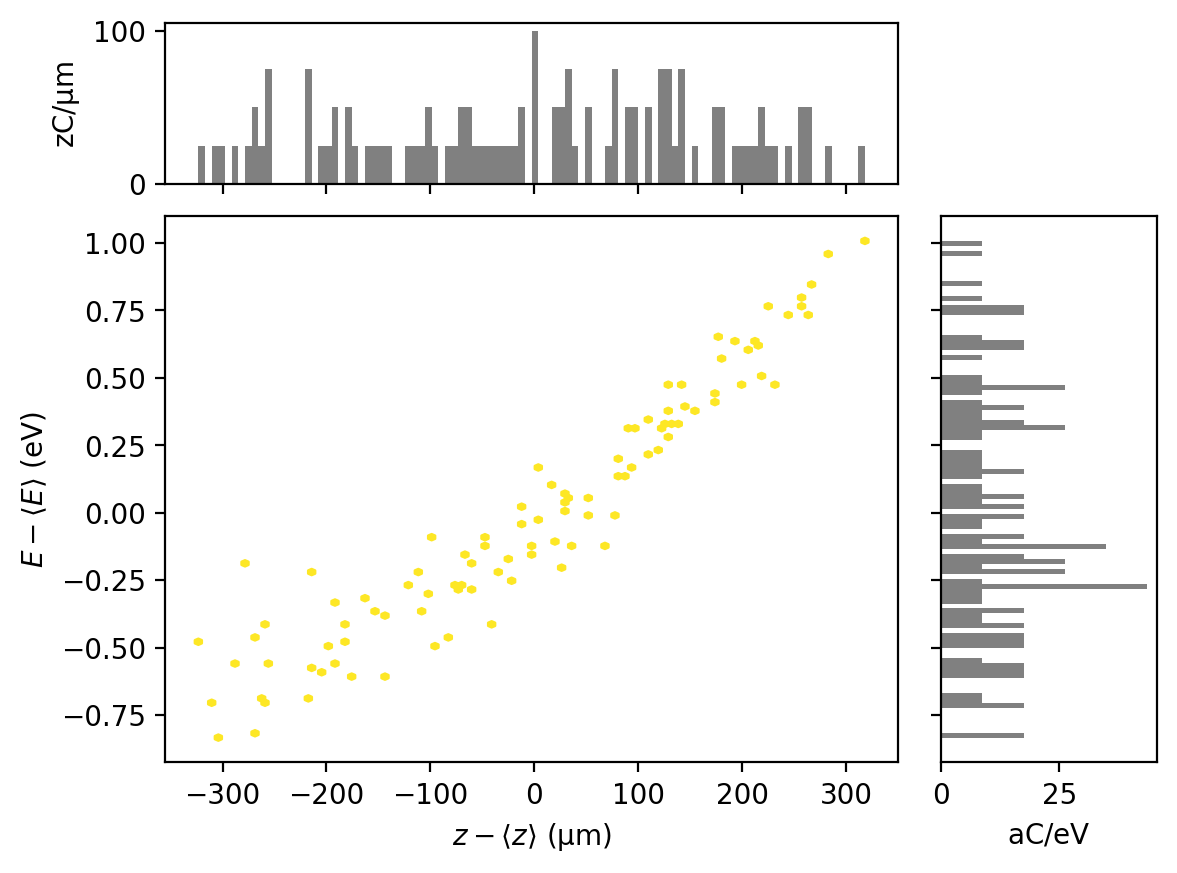

In [19]:
Pon.plot('delta_z', 'delta_energy', bins=100)